# Atividade 2
Aplicar conceitos de Visão Computacional para reconstruir um modelo 3D (nuvem de pontos e/ou malha) de um objeto/cena a partir de múltiplas imagens, desenvolvendo com-
petências em extração de características, emparelhamento, geometria epipolar, estimação de pose, triangulação e (opcionalmente) densificação/malha/texturização.

# Progresso e próximos passos
- [ ] Etapa 1: Coleta das Imagens e Preparação
  - coloque o passo a passo
- [ ] Etapa 2: Detecção e Extração de Características
  - coloque o passo a passo
- [ ] Etapa 3: Emparelhamento e Geometria Epipolar
  - coloque o passoa a passo
- [ ] Etapa 4: Reconstrução 3D e (Opcional) Densificação/Malha
  - coloque o passoa a passo
- [ ] Etapa 5: Avaliação, Demonstração e Relatório
  - coloque o passo a passo
- [ ] Opcional 1: Recuperar escala absoluta
- [ ] Opcional 2: Marcar poses das câmeras no espaço 3D e exportar GLB/OBJ para visualização web.
- [ ] Opcional 3: Tratar casos difíceis: baixa textura, iluminação desafiadora, oclusões, superfícies brilhantes.
- [ ] Opcional 4: Comparar patch-match vs. métodos alternativos de densificação (se aplicável).


## Etapa 1: Preparação das imagens

In [35]:
import os
import re
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [36]:
# drive.mount('/content/drive', force_remount=True)
# input_dir = '/content/drive/MyDrive/mc949/scan6/'
input_dir = 'data/scan6'


In [37]:
# List all files in the input directory
image_files = os.listdir(input_dir)

# Filter files that end with 'max.png'
max_images = [f for f in image_files if re.search(r'max\.png$', f)]



In [38]:
images = [cv2.imread(os.path.join(input_dir, max_image)) for max_image in sorted(max_images)]

## Etapa 2: Detecção e Extração de Características

### Achando os keypoints via SIFT

Detectando os keypoints via SIFT e ORB, mostrando as features em fundo "homogêneo" e então mostrando as imagens sobrepostas aos seus keypoints

In [39]:
def sift_detector(img, n_features=None):
    # Checa se a imagem já está em escala de cinza
    if len(img.shape) == 2:
        gray_img = img
    else:
        # Converte para escala de cinza
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    if n_features:
        # Inicializa o detector SIFT com o número de melhores features desejado
        sift = cv2.SIFT_create(nfeatures=n_features)
    else:
        sift = cv2.SIFT_create()

    # Detecta os keypoints
    keypoints = sift.detect(gray_img, None)

    return keypoints

sift_keypoints = [sift_detector(img=img) for img in images]
print(f"Número de keypoints encontrados pelo sift: {[len(kp) for kp in sift_keypoints]}")

sift_keypoints_filtered = [sift_detector(img=img, n_features=500) for img in images]
print(f"Número de keypoints encontrados pelo sift pós-filtragem: {[len(kp) for kp in sift_keypoints_filtered]}")

Número de keypoints encontrados pelo sift: [14631, 16473, 16939, 17261, 14783, 13564, 15724, 16800, 16654, 15507, 15025, 11986, 14166, 15272, 16232, 16710, 17247, 16513, 12629, 8773, 15087, 17320, 17071, 16627, 15945, 15321, 14630, 12588, 9770, 11633, 13282, 14044, 14425, 15468, 15448, 16137, 15620, 12974, 8429, 12514, 13982, 14104, 13464, 13562, 12569, 12044, 11466, 10076, 8682]
Número de keypoints encontrados pelo sift pós-filtragem: [500, 500, 501, 501, 501, 502, 500, 500, 500, 501, 500, 500, 500, 500, 500, 500, 500, 500, 500, 501, 501, 501, 500, 500, 500, 500, 500, 501, 500, 500, 500, 500, 500, 500, 501, 500, 500, 501, 500, 500, 500, 501, 500, 500, 500, 501, 500, 500, 500]


### Achando os keypoints via ORB

In [40]:
def orb_detector(img, nfeatures=30000):
    # Check if image is already grayscale
    if len(img.shape) == 2:
        gray_img = img
    else:
        # Convert to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Initialize ORB detector
    orb = cv2.ORB_create(nfeatures=nfeatures)
    kp  = orb.detect(gray_img, None)

    return kp

orb_keypoints = [orb_detector(img) for img in images]
print(f"Número de keypoints encontrados pelo orb: {[len(kp) for kp in orb_keypoints]}")

orb_keypoints_filtered = [orb_detector(img, nfeatures=500) for img in images]
print(f"Número de keypoints encontrados pelo orb pós-filtragem: {[len(kp) for kp in orb_keypoints_filtered]}")

Número de keypoints encontrados pelo orb: [29094, 29641, 29831, 29813, 29306, 29173, 29700, 29731, 29792, 29558, 29382, 28636, 29112, 29238, 29362, 29635, 29711, 29509, 29112, 27055, 29040, 29589, 29665, 29294, 29299, 29231, 29071, 28596, 27090, 28079, 28536, 29064, 29101, 29098, 29263, 29265, 29013, 28450, 25674, 28291, 28755, 28816, 28543, 28369, 28307, 28279, 27719, 26693, 25553]
Número de keypoints encontrados pelo orb pós-filtragem: [500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500, 500]



 Keypoints SIFT para a imagem 1:


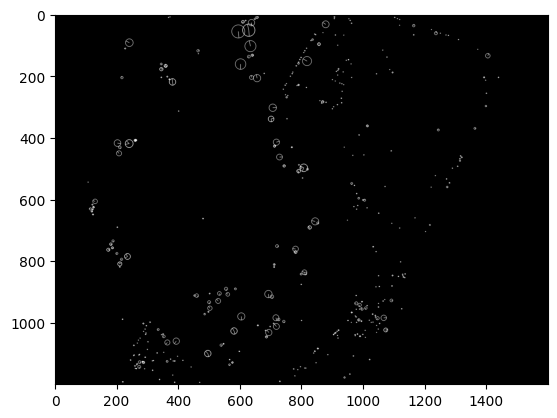


 Keypoints SIFT para a imagem 2:


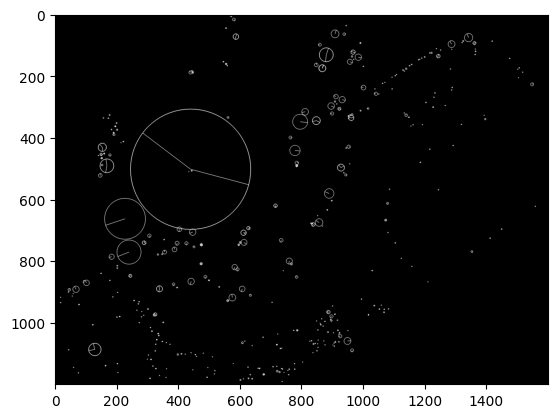

In [41]:
n = 2
for i in range(n):
    black_canvas_sift_filtered = np.zeros_like(images[i])
    image_with_sift_filtered_keypoints_on_black = cv2.drawKeypoints(black_canvas_sift_filtered, sift_keypoints_filtered[i], None, color=(255, 255, 255), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print(f"\n Keypoints SIFT para a imagem {i+1}:")
    #cv2_imshow(image_with_sift_filtered_keypoints_on_black)
    plt.imshow(image_with_sift_filtered_keypoints_on_black)
    plt.show()

Sobreposição dos keypoints SIFT para imagem 1


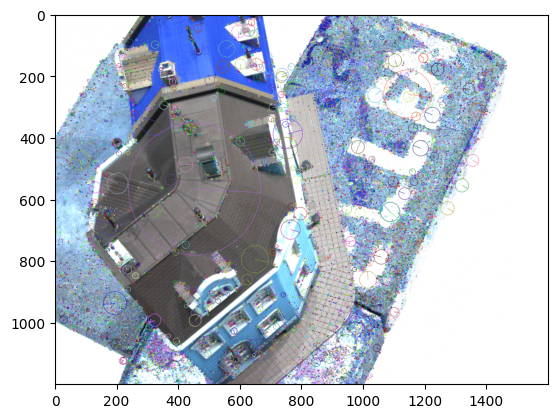

Sobreposição dos keypoints SIFT para imagem 2


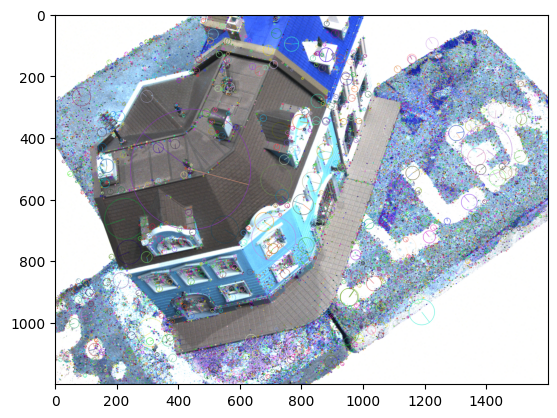

In [42]:
n = 2
for i in range(n):
  image_with_keypoints = cv2.drawKeypoints(images[i], sift_keypoints[i], None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  print(f"Sobreposição dos keypoints SIFT para imagem {i+1}")
  #cv2_imshow(image_with_keypoints)
  plt.imshow(image_with_keypoints)
  plt.show()

## Etapa 3: Emparelhamento e Geometria Epipolar

In [43]:
def sift_descriptor(img, kp):
     sift = cv2.SIFT_create()
     sift_descriptors = sift.compute(img, kp)

     return sift_descriptors[1]

In [44]:
# Match features using FLANN matcher
def flann_matcher(img1, img2, n_features=None):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # Filter the keypoints
    if n_features:
      kp1 = sift_detector(img1, n_features=n_features)
      kp2 = sift_detector(img2, n_features=n_features)
    else:
      kp1 = sift_detector(img1)
      kp2 = sift_detector(img2)

    des1 = sift_descriptor(img1, kp1)
    des2 = sift_descriptor(img2, kp2)
    mtch = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for match_pair in mtch:
        if len(match_pair) == 2:
            m, n = match_pair
            if m.distance < 0.7 * n.distance:
                good_matches.append(m)

    if len(good_matches) < 4:
        return None, None

    good_matches_sorted = sorted(good_matches, key=lambda x: x.distance)

    # Extract matched points
    src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches_sorted]).reshape(-1, 1, 2)
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches_sorted]).reshape(-1, 1, 2)

    return src_pts, dst_pts, good_matches_sorted

matches = []
for i in range(len(images) - 1):
    src_pts, dst_pts, good_matches = flann_matcher(images[i], images[i+1], n_features=500)
    matches.append(good_matches[:100])

print(f"Number of good matches found between consecutive images: {[len(m) for m in matches]}")

Number of good matches found between consecutive images: [87, 80, 57, 46, 60, 32, 36, 83, 100, 100, 85, 100, 100, 100, 100, 88, 82, 38, 29, 31, 66, 100, 100, 100, 100, 100, 100, 75, 100, 100, 100, 100, 100, 100, 100, 100, 74, 30, 55, 100, 100, 100, 100, 100, 100, 100, 100, 82]


Visualizando Matchings


 80 Matches between image 2 and image 3:


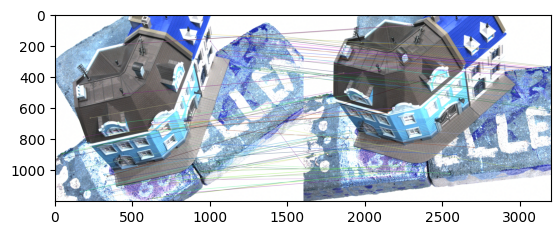

In [ ]:
# Visualize the matches between consecutive images
i = 1
if len(matches[i]) > 0:
    img1 = images[i]
    img2 = images[i+1]
    # Draw matches
    img_matches = cv2.drawMatches(img1, sift_keypoints_filtered[i], img2, sift_keypoints_filtered[i+1], matches[i], None, flags=2)
    print(f"\n {len(matches[i])} Matches between image {i+1} and image {i+2}:")
    #cv2_imshow(img_matches)
    plt.imshow(img_matches)
    plt.show()
else:
    print(f"No good matches found between image {i+1} and image {i+2}.")

Estimar poses das câmeras (R,t) e triangular pontos 3D iniciais

In [72]:
from mpl_toolkits.mplot3d import Axes3D

def estimate_pose(kp1, kp2,  src_pts, dst_pts, matches, K, method=cv2.RANSAC, prob=0.999, threshold=1.0):
    """
    Estimate the relative pose between two cameras using matched features.
    """
    # Estimate essential matrix
    E, mask = cv2.findEssentialMat(src_pts, dst_pts, K, method, prob, threshold)
    
    # Recover pose from essential matrix
    _, R, t, mask = cv2.recoverPose(E, src_pts, dst_pts, K, mask=mask)
    
    inlier_matches = [matches[i] for i in range(len(matches)) if mask[i] > 0]
    print(f"Estimated pose with {np.sum(mask)} inliers out of {len(matches)} matches")
    
    return E, R, t, mask, inlier_matches

In [73]:
def triangulate_points(kp1, kp2, matches, K, R1, t1, R2, t2):
    """
    Triangulate 3D points from two views.
    """

    # Extract matched points
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    
    # Create projection matrices
    P1 = np.dot(K, np.hstack((R1, t1)))
    P2 = np.dot(K, np.hstack((R2, t2)))
    
    # Triangulate points
    points_4d = cv2.triangulatePoints(P1, P2, pts1.T, pts2.T)
    
    # Convert to 3D points
    points_3d = points_4d[:3] / points_4d[3]
    
    return points_3d.T

In [74]:
def visualize_points_and_cameras(points_3d, R1, t1, R2, t2):
    """
    Visualize 3D points and camera positions.
    """

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Plot points
    ax.scatter(points_3d[:, 0], points_3d[:, 1], points_3d[:, 2], c='b', s=1)
    
    # Helper function to create camera visualization
    def plot_camera(R, t, color):
        # Camera center
        center = -R.T @ t
        ax.scatter(center[0], center[1], center[2], c=color, s=100, marker='o')
        
        # Camera axes (showing orientation)
        axes_length = 0.5  # Scale to make it visible
        for i, c in zip(range(3), ['r', 'g', 'b']):
            axis = R.T[:, i] * axes_length
            ax.quiver(center[0], center[1], center[2], 
                      axis[0], axis[1], axis[2], 
                      color=c, arrow_length_ratio=0.1)
    
    # Plot cameras
    plot_camera(R1, t1, 'red')
    plot_camera(R2, t2, 'green')
    
    ax.set_title('3D Reconstruction: Points and Cameras')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    # Try to make axes equal
    max_range = np.max([
        np.max(points_3d[:, 0]) - np.min(points_3d[:, 0]),
        np.max(points_3d[:, 1]) - np.min(points_3d[:, 1]),
        np.max(points_3d[:, 2]) - np.min(points_3d[:, 2])
    ])
    
    mid_x = (np.max(points_3d[:, 0]) + np.min(points_3d[:, 0])) * 0.5
    mid_y = (np.max(points_3d[:, 1]) + np.min(points_3d[:, 1])) * 0.5
    mid_z = (np.max(points_3d[:, 2]) + np.min(points_3d[:, 2])) * 0.5
    
    ax.set_xlim(mid_x - max_range * 0.5, mid_x + max_range * 0.5)
    ax.set_ylim(mid_y - max_range * 0.5, mid_y + max_range * 0.5)
    ax.set_zlim(mid_z - max_range * 0.5, mid_z + max_range * 0.5)
    
    plt.tight_layout()
    plt.show()

Pose estimation example

In [75]:
K = np.array([
        [1000, 0, 320],
        [0, 1000, 240],
        [0, 0, 1]
])
    
# For first camera, we use identity rotation and zero translation
R1 = np.eye(3)
t1 = np.zeros((3, 1))

i = 1

img1 = images[i]
img2 = images[i+1]

kp1 = sift_detector(img1)
kp2 = sift_detector(img2)

src_pts, dst_pts, matches = flann_matcher(img1, img2)
# Estimate pose of second camera relative to first
EssentialM, R2, t2, mask, inliers = estimate_pose(kp1, kp2, src_pts, dst_pts, matches, K, threshold=0.5)

Estimated pose with 1443 inliers out of 2070 matches


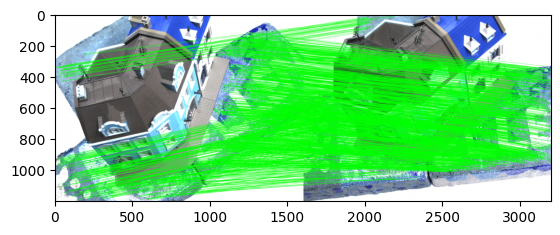

In [79]:
img_inliers = cv2.drawMatches(img1, kp1, img2, kp2, inliers, None,
                              matchColor=(0,255,0), singlePointColor=None,
                              flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
plt.imshow(img_inliers)

Linhas epipolares

In [85]:
def draw_epilines(img1_color, img2_color, lines, pts1, pts2):
    r, c = img1.shape[:2]
    for r_line, pt1, pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0, y0 = map(int, [0, -r_line[2]/r_line[1]])
        x1, y1 = map(int, [c, -(r_line[2]+r_line[0]*c)/r_line[1]])
        img1_color = cv2.line(img1_color, (x0,y0), (x1,y1), color,1)
        img1_color = cv2.circle(img1_color, tuple(np.int32(pt1).ravel()), 5, color, -1)
        img2_color = cv2.circle(img2_color, tuple(np.int32(pt2).ravel()), 5, color, -1)
    return img1_color, img2_color

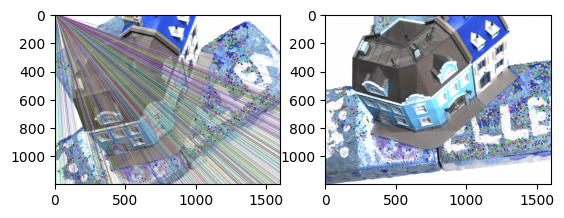

In [91]:
lines1 = cv2.computeCorrespondEpilines(src_pts.reshape(-1,1,2), 1, EssentialM)
lines1 = lines1.reshape(-1,3)

# pts2 → linhas em img1
lines2 = cv2.computeCorrespondEpilines(dst_pts.reshape(-1,1,2), 2, EssentialM)
lines2 = lines2.reshape(-1,3)

img1_epi, img2_epi = draw_epilines(img1, img2, lines1, src_pts[mask.ravel()==1], dst_pts[mask.ravel()==1])
fig, ax = plt.subplots(1,2)
ax[0].imshow(img1_epi)
ax[1].imshow(img2_epi)
plt.show()

Visualizing the points and cameras

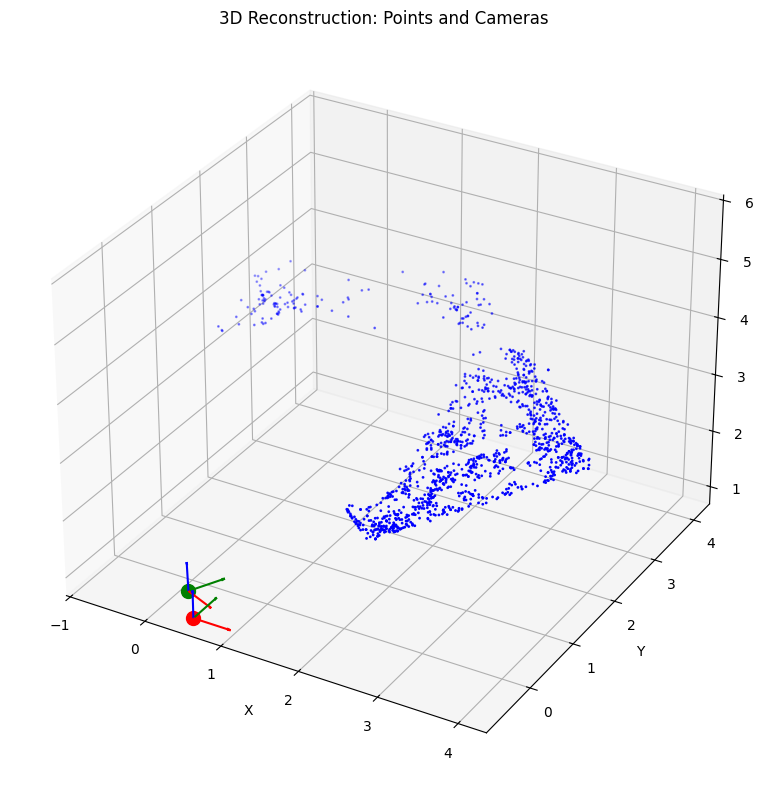

In [ ]:
# Triangulate points
points_3d = triangulate_points(kp1, kp2, inliers, K, R1, t1, R2, t2)

visualize_points_and_cameras(points_3d, R1, t1, R2, t2)